**Install and Import Required Libraries**

In [4]:
pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached s

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Input, GlobalAveragePooling1D, Permute
from tensorflow.keras.models import Model

2025-05-21 11:19:49.601057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 11:19:49.601605: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 11:19:49.604400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 11:19:49.612039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747797589.624642   53803 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747797589.62

**Set Dataset Paths and Image Parameters**

In [3]:
train_dir = "Training"
test_dir = "Testing"

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:
def mlp_block(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation='gelu')(x)
        x = Dropout(dropout_rate)(x)
    return x

def build_mlp_mixer(img_size, patch_size, num_classes, hidden_dim=128, tokens_mlp_dim=64, channels_mlp_dim=256, num_blocks=4, dropout_rate=0.2):
    input_shape = (img_size, img_size, 3)
    inputs = Input(shape=input_shape)

    # Split image into patches
    num_patches = (img_size // patch_size) ** 2
    projection_dim = hidden_dim

    # Patch embedding
    x = tf.keras.layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    x = tf.keras.layers.Reshape((num_patches, projection_dim))(x)

    for _ in range(num_blocks):
        # Token-mixing
        y = LayerNormalization()(x)
        y = Permute((2, 1))(y)
        y = mlp_block(y, [tokens_mlp_dim], dropout_rate)
        y = Permute((2, 1))(y)
        x = x + y  # Skip connection

        # Channel-mixing
        y = LayerNormalization()(x)
        y = mlp_block(y, [channels_mlp_dim], dropout_rate)
        x = x + y  # Skip connection

    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Usage
img_size = 128
patch_size = 16
num_classes = 4

model = build_mlp_mixer(
    img_size=img_size,
    patch_size=patch_size,
    num_classes=num_classes,
    hidden_dim=128,
    tokens_mlp_dim=64,
    channels_mlp_dim=128, 
    num_blocks=4,
    dropout_rate=0.2
)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-05-21 11:20:01.556960: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 128) │     98,432 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 128)   │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 128)   │        256 │ reshape[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 128, 64)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 64)   │      4,160 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 64)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 64, 128)   │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128)   │          0 │ reshape[0][0],    │
│                     │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 128)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_2 (Permute) │ (None, 128, 64)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 64)   │      4,160 │ permute_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 64, 128)   │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 128)   │          0 │ add_1[0][0],      │
│                     │                   │            │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64, 128)   │     16,512 │ layer_normalizat

 Total params: 183,940 (718.52 KB)

 Trainable params: 183,940 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)


Epoch 1/10


/home/paolo/Documents/code/Notebooks/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.4996 - loss: 1.1579 - val_accuracy: 0.7376 - val_loss: 0.7598
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8213 - loss: 0.5119 - val_accuracy: 0.7902 - val_loss: 0.5432
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8604 - loss: 0.3848 - val_accuracy: 0.7666 - val_loss: 0.6150
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8871 - loss: 0.3112 - val_accuracy: 0.8261 - val_loss: 0.4883
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8952 - loss: 0.2726 - val_accuracy: 0.8703 - val_loss: 0.3721
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9136 - loss: 0.2392 - val_accuracy: 0.8474 - val_loss: 0.3900
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9160 - loss: 0.2228 - val_accuracy: 0.8719 - val_loss: 0.3321
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9344 - loss: 0.1750 - val_accurac

In [1]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2f}")

NameError: name 'model' is not defined

### Evaluate the Model: Classification Report and Confusion Matrix

After training the CNN model, we evaluate its performance on the test dataset using several important metrics:

- **`model.predict()`**: Generates prediction probabilities for each test image.
- **`np.argmax`**: Converts probabilities to predicted class labels.
- **`classification_report`**: Provides a detailed breakdown of:
  - **Precision**: How many selected items are relevant.
  - **Recall**: How many relevant items are selected.
  - **F1-Score**: Harmonic mean of precision and recall.
  - **Support**: Number of true samples per class.
- **`confusion_matrix`**: Displays a matrix comparing true labels with predicted labels, allowing us to see which classes were misclassified.

This evaluation helps us understand how well the model performs across all four classes.

In [9]:
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
labels = list(test_data.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.82      0.88       300
  meningioma       0.80      0.86      0.83       306
     notumor       0.97      0.97      0.97       405
   pituitary       0.92      0.97      0.95       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311

Confusion Matrix:
[[245  47   0   8]
 [ 12 264  13  17]
 [  1  11 393   0]
 [  2   6   0 292]]


### Visualize Training and Validation Accuracy

This plot shows how the model’s **training accuracy** and **validation accuracy** changed over each epoch.

- A rising training accuracy indicates the model is learning from the data.
- A close match between training and validation accuracy suggests good generalization.
- A large gap between them may indicate overfitting (i.e., the model is memorizing training data but not performing well on new data).

By visualizing accuracy trends, we can assess whether the model’s performance is improving and whether training should continue for more epochs.

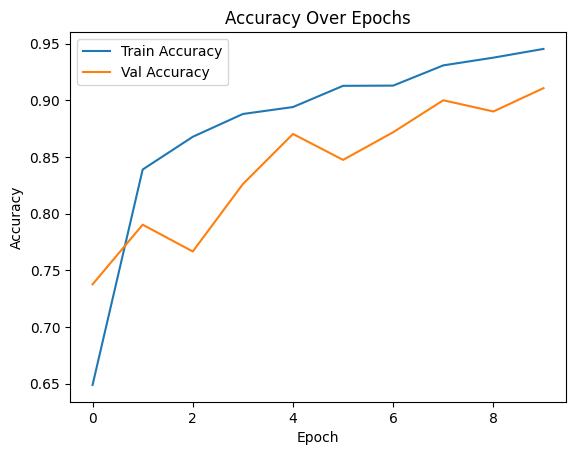

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Detailed Evaluation with Metrics and Heatmap

In this section, we perform a **deeper evaluation** of the trained CNN using several key performance indicators:

#### Step-by-step breakdown:

- **Predictions**: We generate class predictions using the model on the test dataset.
- **Confusion Matrix**: A heatmap is plotted using Seaborn to visualize the true vs. predicted class labels. This helps identify where the model is making correct or incorrect predictions.
- **Classification Report**: We display the precision, recall, and F1-score for each class to assess the model’s performance at a granular level.
- **Summary Metrics**:
  - `accuracy_score`: Overall correct predictions out of all predictions.
  - `f1_score (macro)`: Average F1-score treating all classes equally.
  - `f1_score (weighted)`: F1-score weighted by class support, useful for imbalanced data.
  - `precision_score` & `recall_score (macro)`: Additional metrics to assess model reliability.

This step ensures that the model is not just accurate overall, but also performs well across **each brain tumor type**.

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


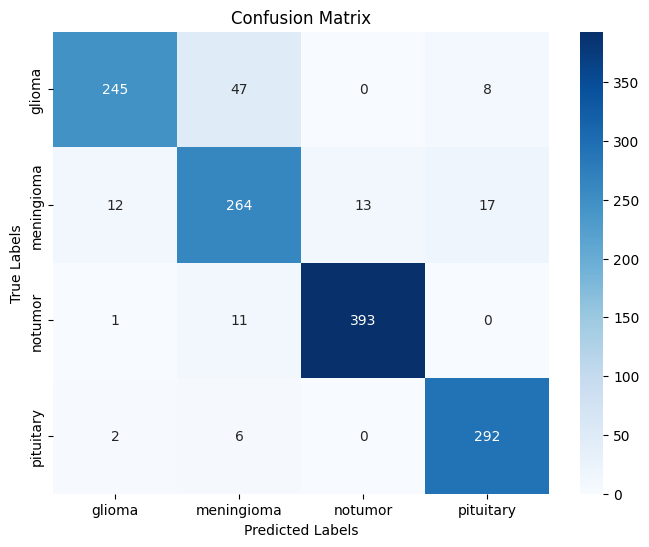

Classification Report (Per Class):
              precision    recall  f1-score   support

      glioma       0.94      0.82      0.88       300
  meningioma       0.80      0.86      0.83       306
     notumor       0.97      0.97      0.97       405
   pituitary       0.92      0.97      0.95       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311


 Accuracy: 0.9108
 Macro F1-Score: 0.9059
 Weighted F1-Score: 0.9106
 Macro Precision: 0.9091
 Macro Recall: 0.9058


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predictions and true labels
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Step 3: Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
print("Classification Report (Per Class):")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Step 4: Summary Metrics
accuracy = accuracy_score(y_true, y_pred_classes)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
precision_macro = precision_score(y_true, y_pred_classes, average='macro')
recall_macro = recall_score(y_true, y_pred_classes, average='macro')

print(f"\n Accuracy: {accuracy:.4f}")
print(f" Macro F1-Score: {f1_macro:.4f}")
print(f" Weighted F1-Score: {f1_weighted:.4f}")
print(f" Macro Precision: {precision_macro:.4f}")
print(f" Macro Recall: {recall_macro:.4f}")

### Save the Trained Model

After training and evaluating our CNN, we save the final model to a file named `brain_tumor_cnn_model.h5`.

Saving the model allows us to:
- Reuse it later without retraining.
- Deploy it in applications or services.
- Share it with others for reproducibility.


In [16]:
model.save("brain_tumor_mlp_model.keras")

### Load the Saved Model


In [3]:
from tensorflow.keras.models import load_model

# Load saved model (optional if model is already in memory)
model = load_model("brain_tumor_mlp_model.keras")

2025-05-21 11:37:45.442399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 11:37:45.442925: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 11:37:45.445559: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 11:37:45.453016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747798665.466467   55772 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747798665.47

### Reload Test Data for Inference

We reload the test dataset using `ImageDataGenerator`, applying only rescaling (no augmentation) since this is for evaluation.

This step is important when:
- The notebook is restarted after saving/loading the model.
- You need to regenerate the `test_data` generator for making predictions.

The images are resized to 150×150 pixels and organized by class folders. Setting `shuffle=False` ensures the predictions align correctly with the ground truth labels for evaluation.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128
batch_size = 32

test_dir = "Testing"

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


### Generate Predictions from the Model

Now that the model and test data are ready, we use the model to generate predictions:

- `model.predict(test_data)`: Returns probability scores for each class for every image.
- `np.argmax(y_probs, axis=1)`: Converts the probability vectors into class index predictions by selecting the class with the highest probability.

These predictions will be used in the next steps for evaluating the model's performance.

In [5]:
import numpy as np

# Get predictions and convert to class indices
y_probs = model.predict(test_data)
y_preds = np.argmax(y_probs, axis=1)

/home/paolo/Documents/code/Notebooks/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


### Final Evaluation Metrics

We now evaluate the model’s predictions using three key metrics:

- **`classification_report`**: Provides a detailed view of the model’s performance for each class, including:
  - Precision
  - Recall
  - F1-Score
  - Support (number of true instances per class)

- **`confusion_matrix`**: Shows how often predictions matched the true labels. It's a useful tool to identify specific types of misclassifications.

- **`accuracy_score`**: Measures the overall percentage of correctly classified instances.

This step confirms the final performance of our CNN model on the test dataset.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# Print metrics
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_preds))

print(f"Accuracy: {accuracy_score(y_true, y_preds):.4f}")

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.82      0.88       300
  meningioma       0.80      0.86      0.83       306
     notumor       0.97      0.97      0.97       405
   pituitary       0.92      0.97      0.95       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311

Confusion Matrix:
[[245  47   0   8]
 [ 12 264  13  17]
 [  1  11 393   0]
 [  2   6   0 292]]
Accuracy: 0.9108


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


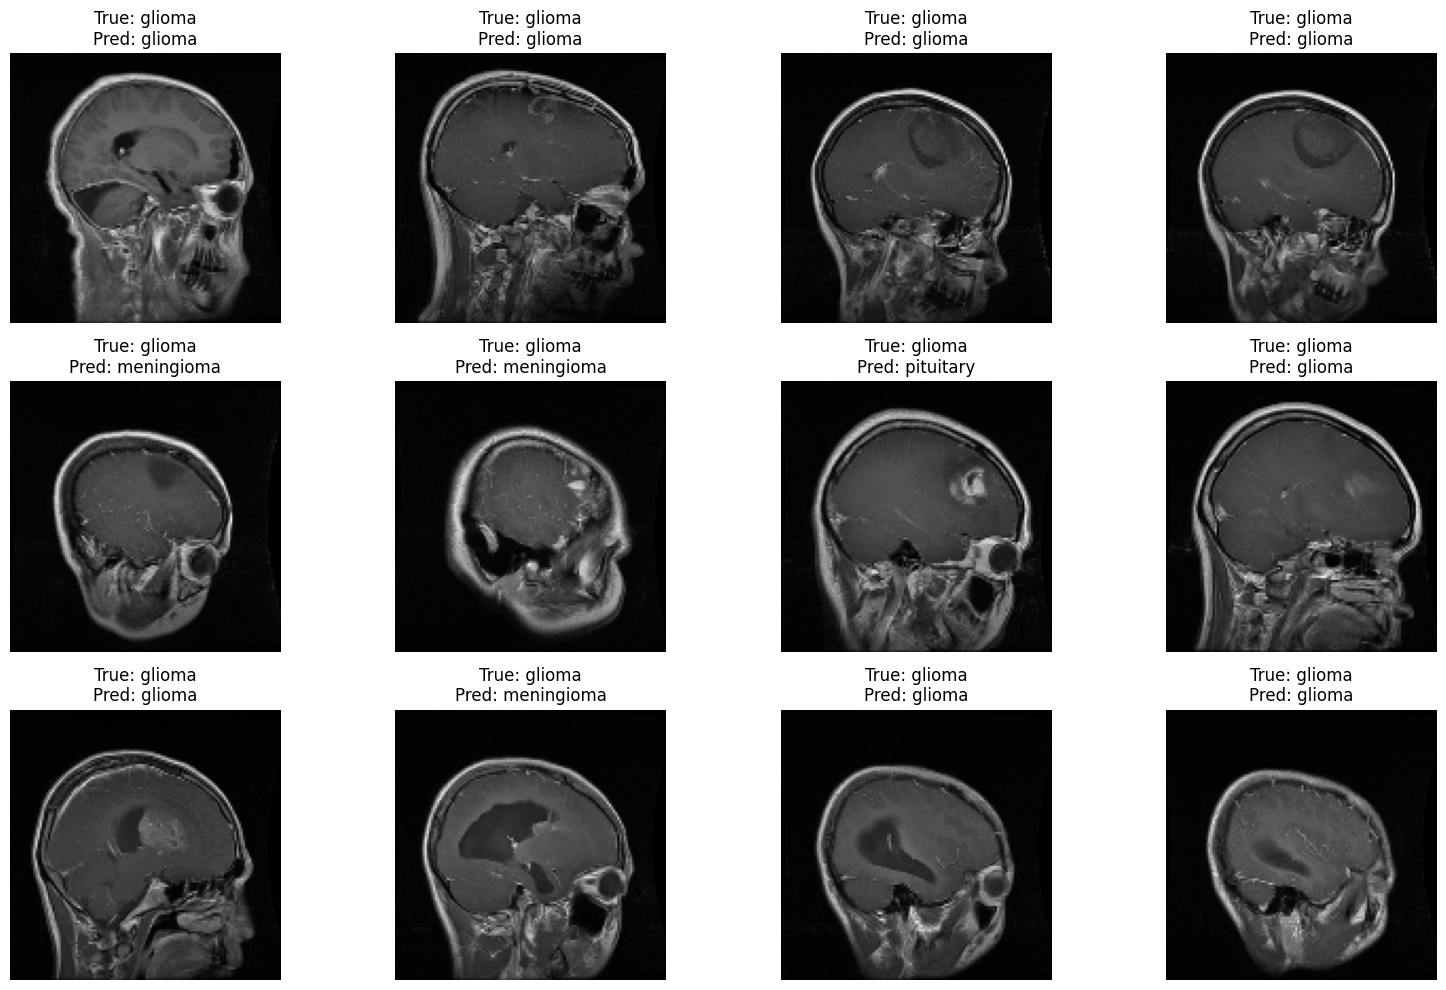

In [13]:
import matplotlib.pyplot as plt

# Show some test images with predictions
x_test, _ = next(test_data)  # get a single batch
predictions = model.predict(x_test)
pred_labels = np.argmax(predictions, axis=1)
num_images = min(12, x_test.shape[0])  # Show up to 12 images or as many as in the batch
plt.figure(figsize=(16, 10))
for i in range(num_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[i])
    # Get true label from one-hot encoded batch
    true_label = class_names[np.argmax(y_true_batch[i])]
    predicted_label = class_names[pred_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()